In [ ]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import polars as pl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
plt.ion()

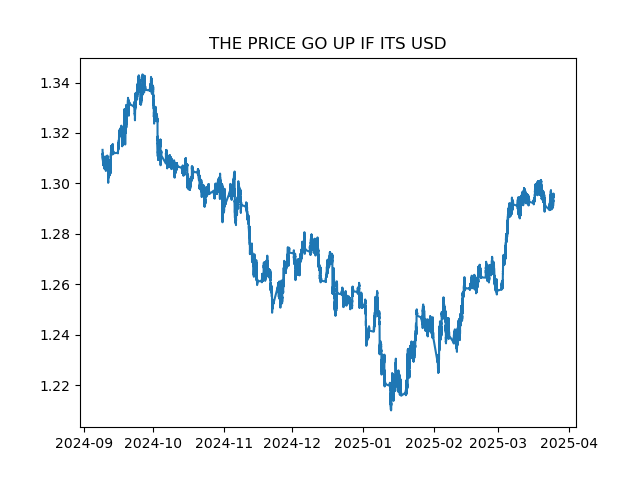

(200000, 1) (200000, 1)


In [91]:
fileName = "GBPUSD_M1.csv"
data = pd.read_csv(fileName)

priceData = pl.DataFrame(data[["Time", "Close"]]).select([
    pl.col("Time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M"),
    pl.col("Close")
])

priceData = (
    priceData.sort(by="Time")
    .group_by_dynamic("Time", every="1m")
    .agg(pl.col("Close").median())
    .drop_nulls()
)

timeSeries = priceData.select(pl.col("Time").dt.timestamp()).to_numpy()
priceSeries = priceData.select(pl.col("Close")).to_numpy()

plt.clf()
plt.plot([datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeries[:,0]],priceSeries)
plt.title("THE PRICE GO UP IF ITS USD")
plt.show()

print(timeSeries.shape, priceSeries.shape)

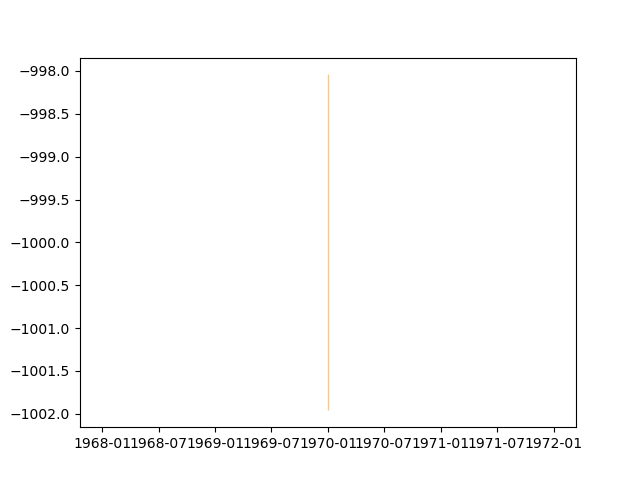

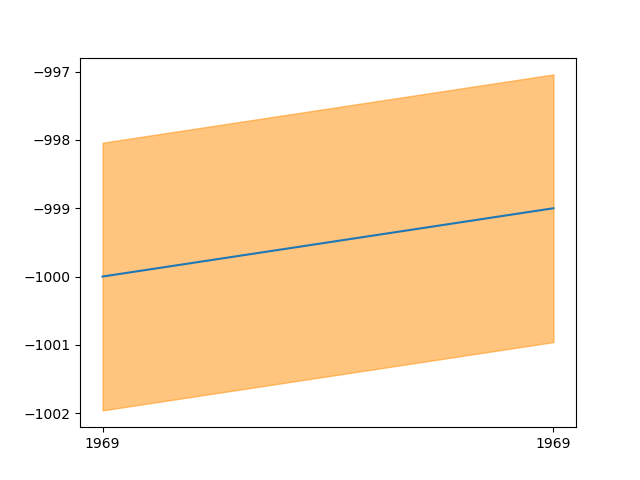

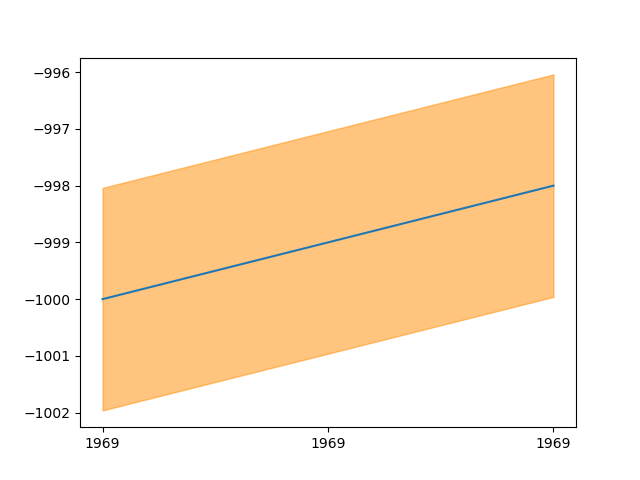

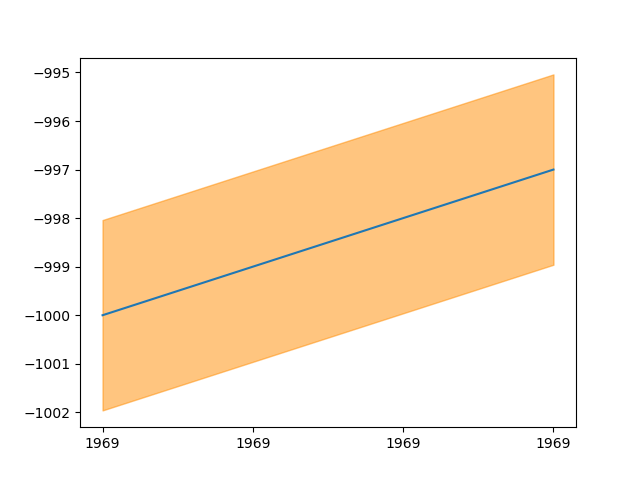

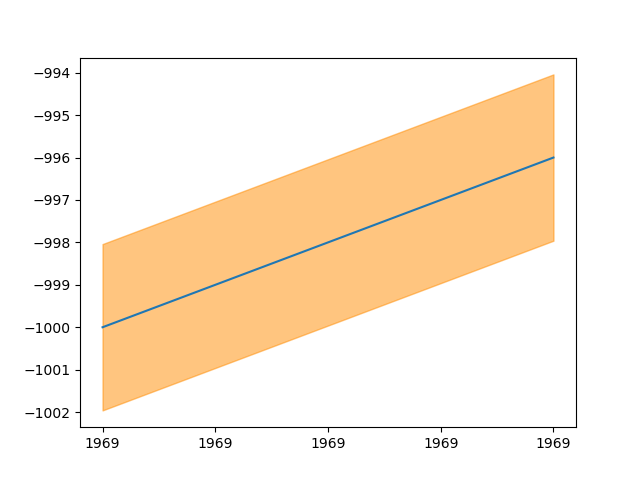

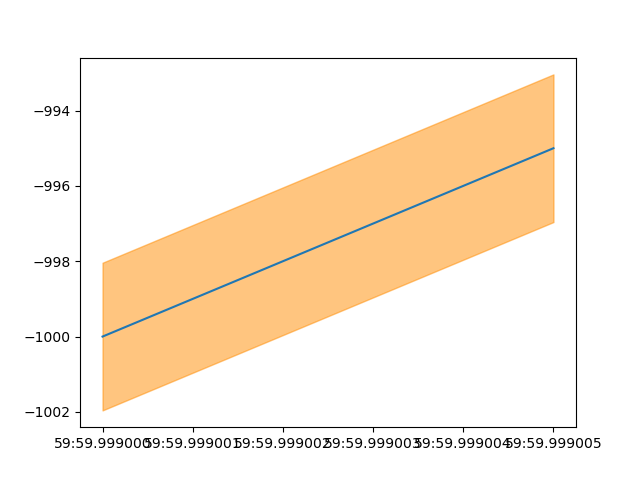

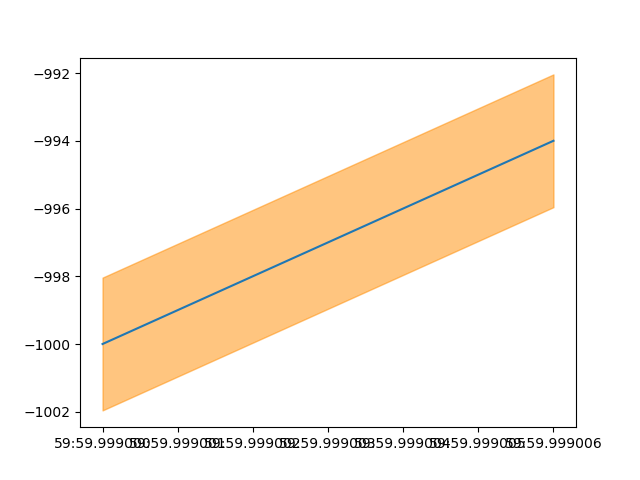

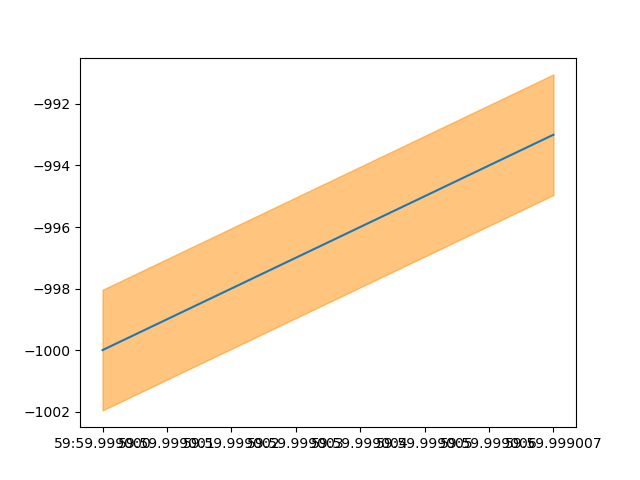

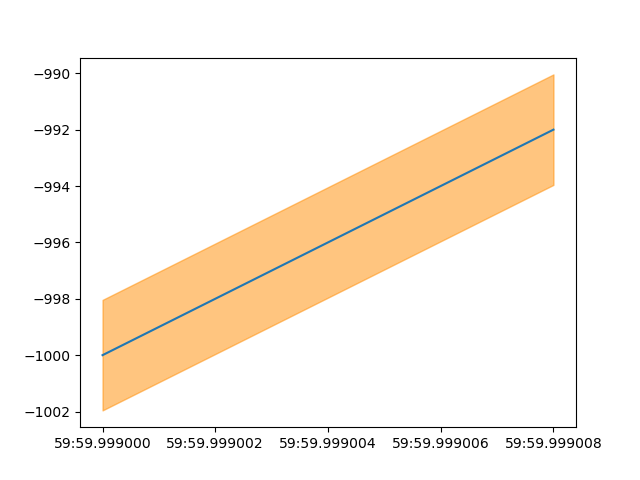

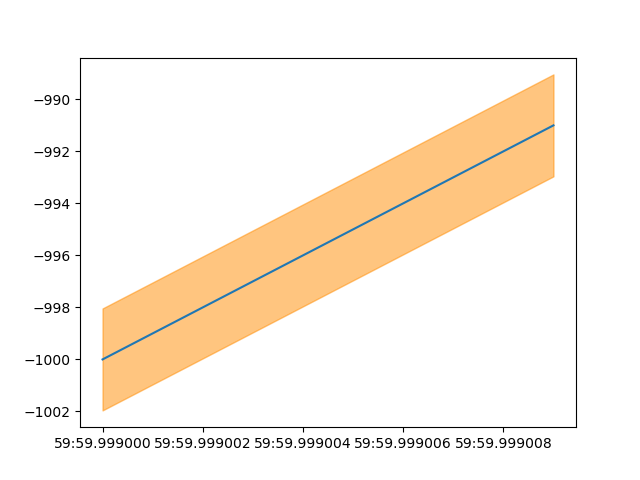

In [99]:
def gprPredict(start, window):
    X = timeSeries[-start-window:-start]
    y = priceSeries[-start-window:-start]

    return start, 1, start

def plotGPR(predictTimeSeries, predictMeanSeries, predictStdSeries, fig):
    plt.clf()
    plt.plot([datetime.fromtimestamp(timestamp/1e6) for timestamp in predictTimeSeries], predictMeanSeries)
    plt.fill_between(
        [datetime.fromtimestamp(timestamp/1e6) for timestamp in predictTimeSeries],
        predictMeanSeries - 1.96 * predictStdSeries,
        predictMeanSeries + 1.96 * predictStdSeries,
        alpha=0.5,
        color='darkorange'
    )
    plt.show()

predictMeanSeries, predictStdSeries, predictTimeSeries = np.array([]), np.array([]), np.array([])
for i in range(10):
    predictMean, predictStd, predictTime = gprPredict(-1000+i, 100)
    predictMeanSeries = np.append(predictMeanSeries, predictMean)
    predictStdSeries = np.append(predictStdSeries, predictStd)
    predictTimeSeries = np.append(predictTimeSeries, predictTime)
    plotGPR(predictTimeSeries, predictMeanSeries, predictStdSeries, fig)
